In [1]:
from traffic import rho_red_light, computeF
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(nx, rho_max, rho_in)
    Computes "red light" initial condition with shock
    
    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 
    
    Returns
    -------
    rho: array of floats
        Array with initial values of density



In [3]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [4]:
#ICs and parameters
nx = 101
nt = 30
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.
V_max = 1.
x = numpy.linspace(0, 4, nx-1)

rho = rho_red_light(nx - 1, rho_max, rho_in)

In [5]:
def animate(data):
    x = numpy.linspace(0, 4, nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [10]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """Computes solution with Godunov scheme using Lax-Friedrichs flux.
    Parameters:
        rho - density at current time step
        nt - number of time steps
        dt - time discretization
        dx - space discretization
        rho_max - max car density
        V_max - max velocity
        
    Returns:
        rho_n - dnesity after nt time steps at each point x
    """
    
    rho_n = numpy.zeros((nt, len(rho)))
    rho_n[:,:] = rho.copy()
    
    #set up some temp. arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    
    for t in range(1, nt):
        rho_plus[:-1] = rho[1:] #
        rho_minus = rho.copy() #array at index i is at location i+1/2
        flux = 0.5*(computeF(V_max, rho_max, rho_minus) + \
            computeF(V_max, rho_max, rho_plus) + dx/dt*(rho_minus \
                                                        - rho_plus))
        rho_n[t, 1:-1] = rho[1:-1] + dt/dx*(flux[:-2] - flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t, -1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n
        

In [11]:
sigma = 1.
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)


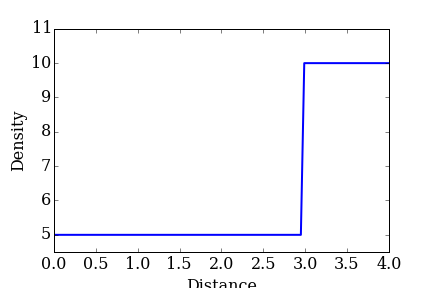
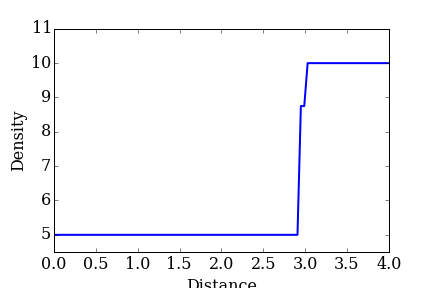
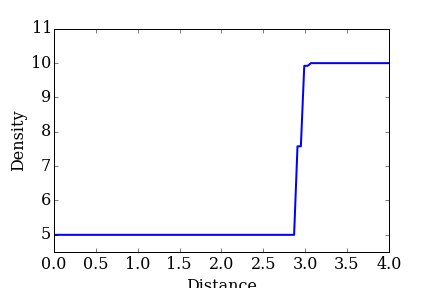
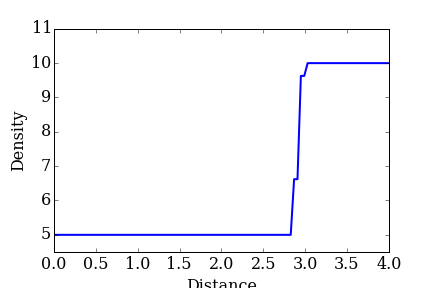
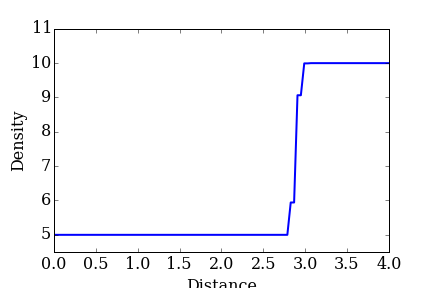
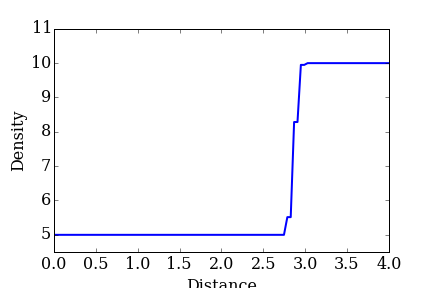
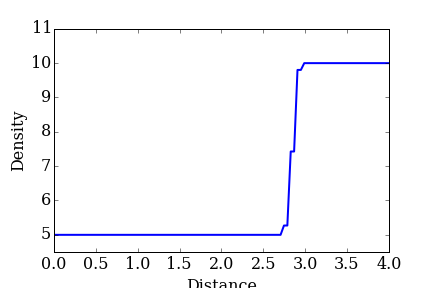
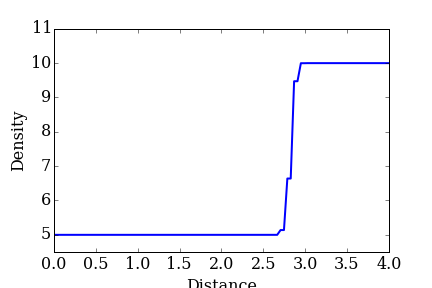
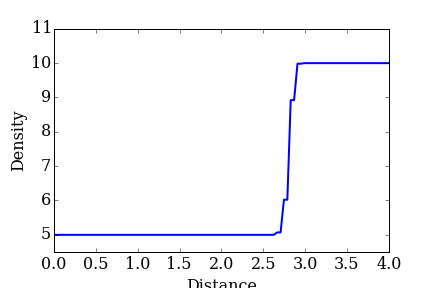
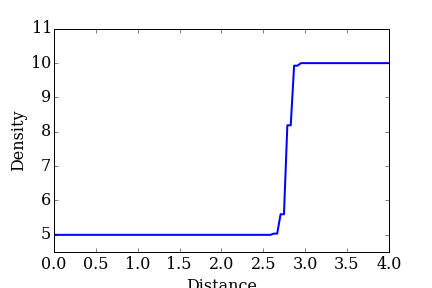
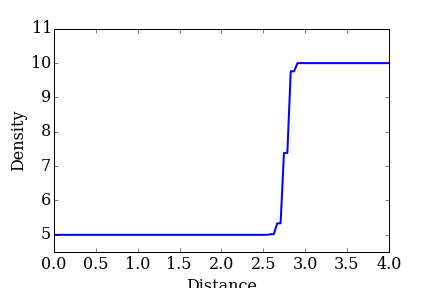
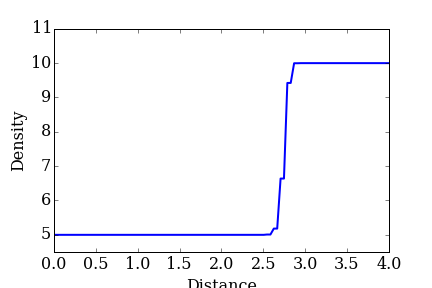
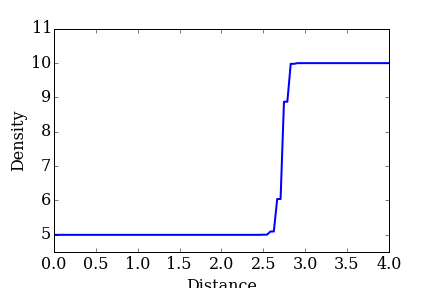
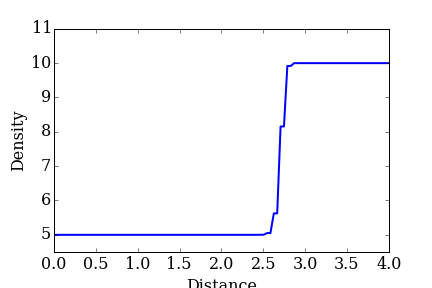
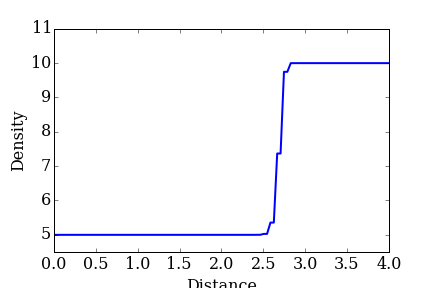
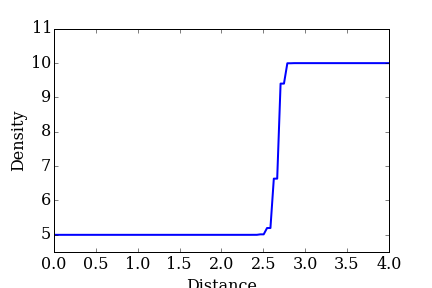
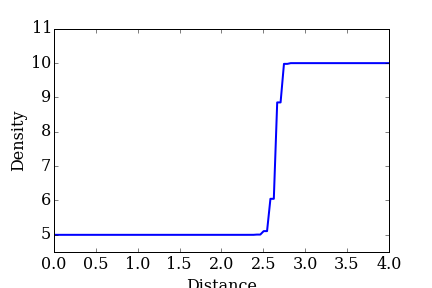
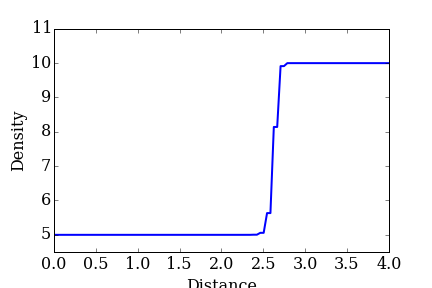
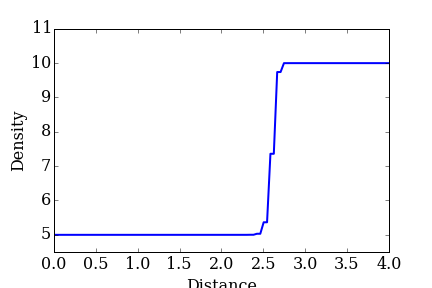
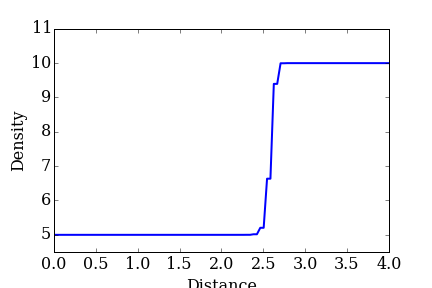
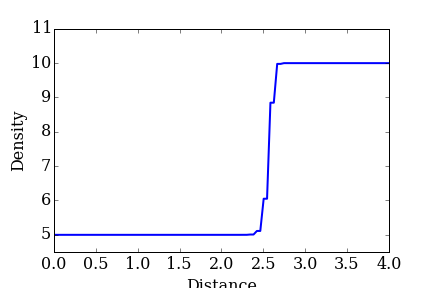
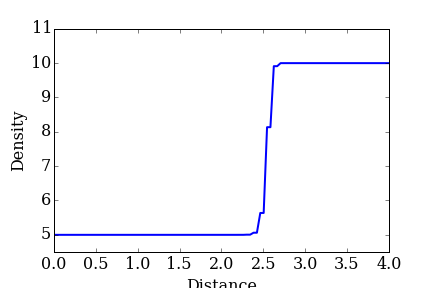
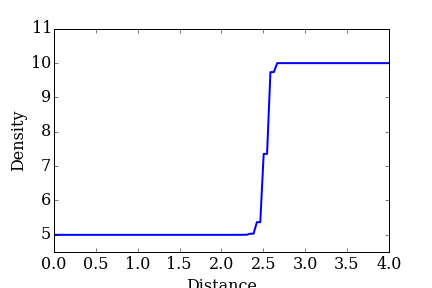
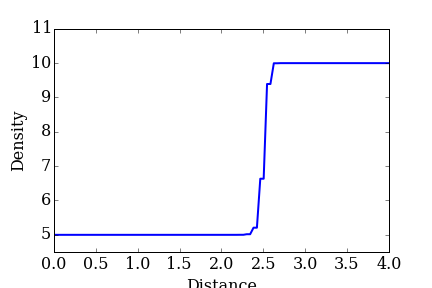
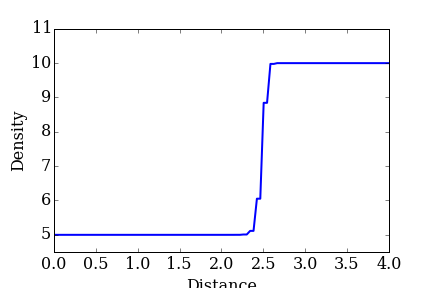
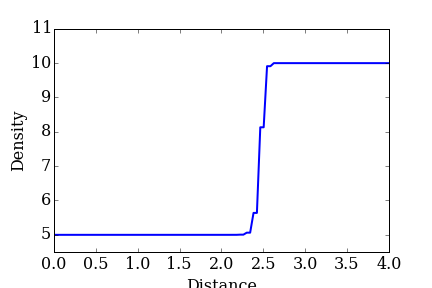
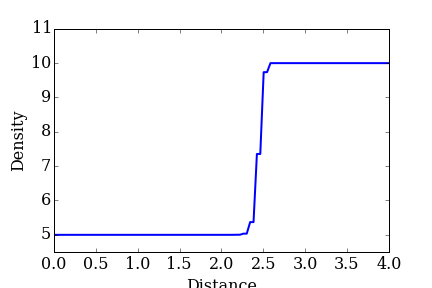
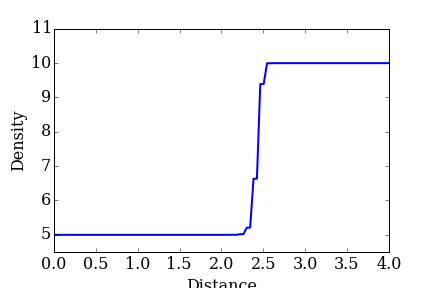
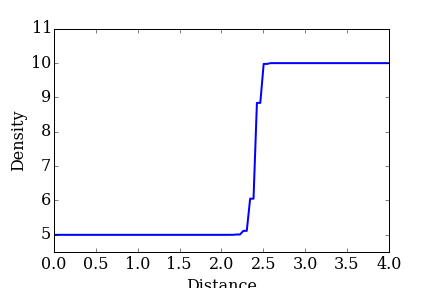
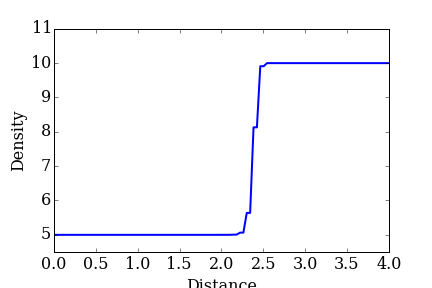

In [13]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(4.5, 11), xlabel=('Distance'), ylabel=('Density'))
line, = ax.plot([], [], lw = 2)

anim = animation.FuncAnimation(fig, animate, frames = rho_n, interval = 50)
display_animation(anim, default_mode='once')

Dig Deeper:


    Godunov's method works in problems having waves moving with positive or negative wave speeds. Try it on the green-light problem introduced in lesson 1 using the initial condition containing waves traveling in both directions.

    Investigate two or three different numerical flux schemes (you can start with van Leer et al., 1987, or Google for other references. Implement the different flux schemes and compare!



In [14]:
def minmod(e, dx):
    """Compute the minmod approximation for slope
    Parameters: 
        e - input data
        dx - spatial discretization
        
    Returns:
        sigma - minmod slope
    """
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    for i in range(1, len(e)-1):
        if (de_minus[i]*de_plus[i] < 0.0):
            sigma[i] = 0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

In [18]:
def muscl(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the MUSCL scheme using Lax-Friedrichs flux
         uses RK2 in time and minmod slope limiting
         
        Parameters:
            rho - density at current time step
            nt - number of time steps 
            dt - time discretization
            dx - spatial discretization
            rho_max - max density
            V_max - max velocity
    """
    
    rho_n = numpy.zeros((nt, len(rho)))
    rho_n[:,:] = rho.copy()
    
    #temporary arrays
    rho_plu = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)
    
    for t in range(1, nt):
        sigma = minmod(rho, dx) # calculate minmod slope
        
        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux_i = i+1/2
        flux[:-1] = 0.5*(flux_right[1:] + flux_left[:-1] - dx/dt *\
                        (rho_right[1:] - rho_left[:-1]))
        
        #RK2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx*(flux[:-2] - flux[1:-1])
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        sigma = minmod(rho_star, dx)
        
        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5*(flux_right[1:] + flux_left[:-1] - dx/dt *\
                        (rho_right[1:] - rho_left[:-1]))
        
        rho_n[t, 1:-1]= 0.5*(rho[1:-1] + rho_star[1:-1] + dt/dx*(flux[:-2]-flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [19]:
sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in)
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)


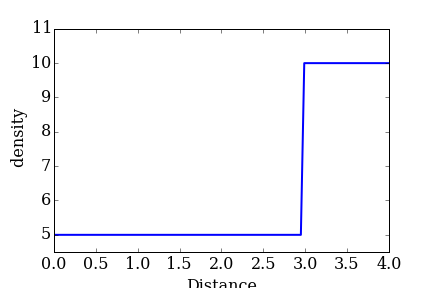
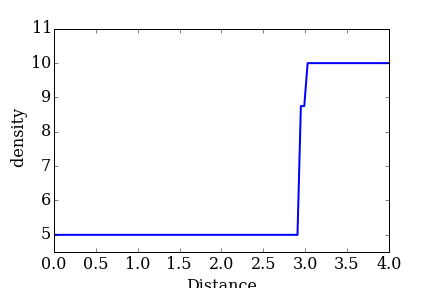
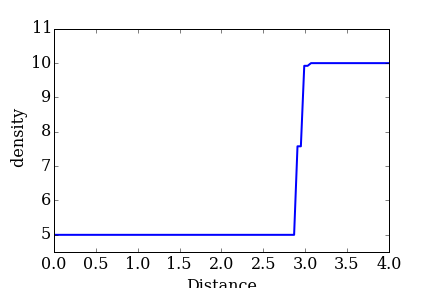
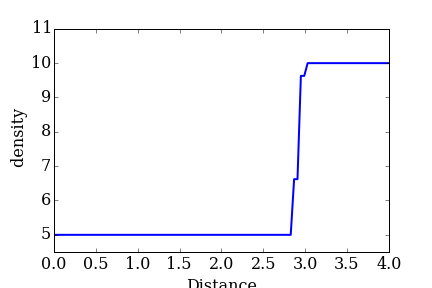
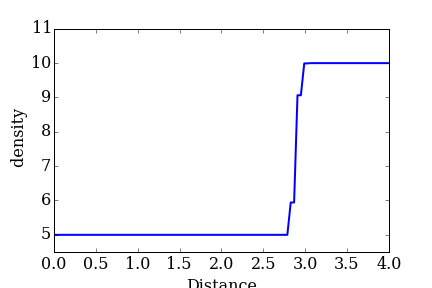
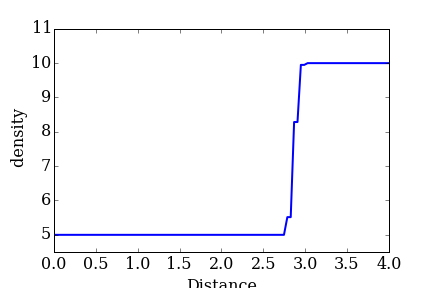
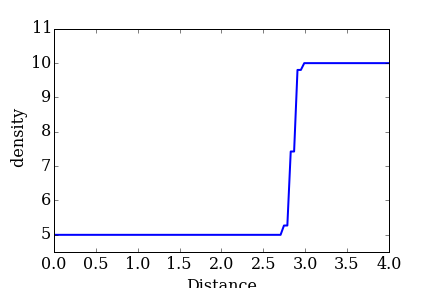
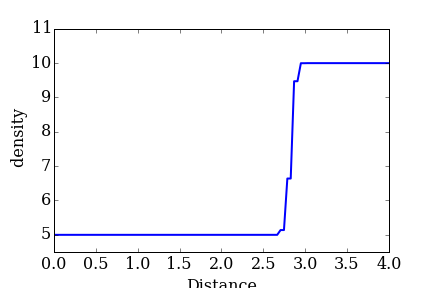
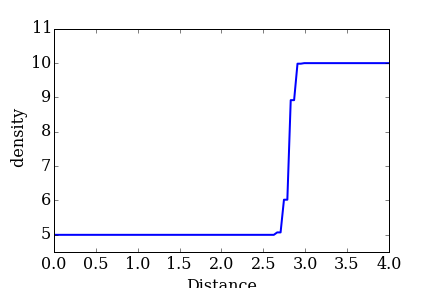
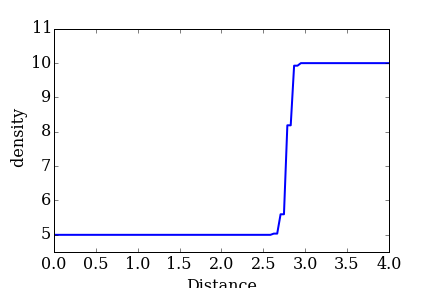
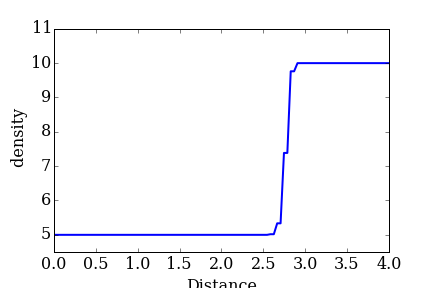
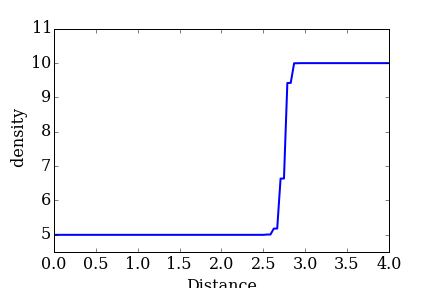
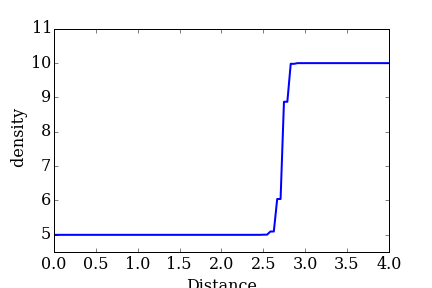
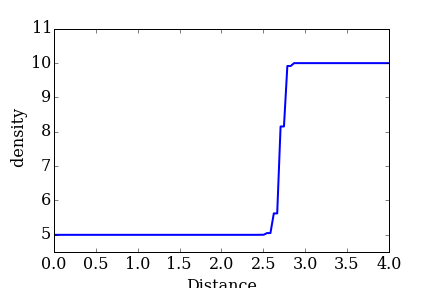
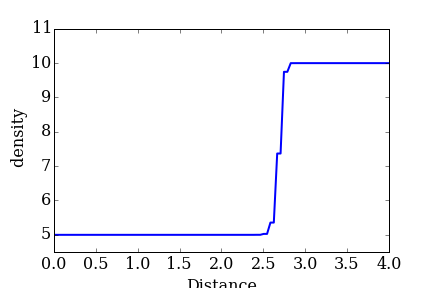
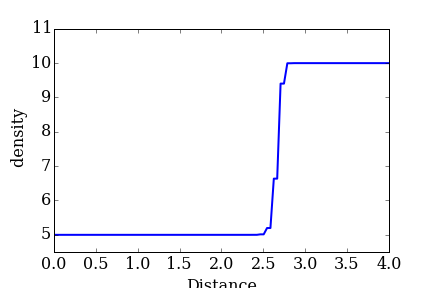
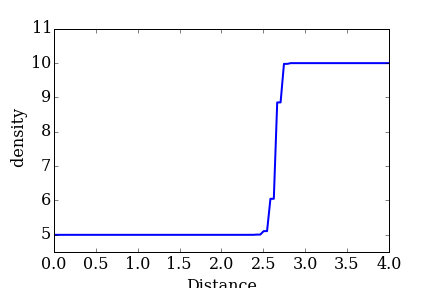
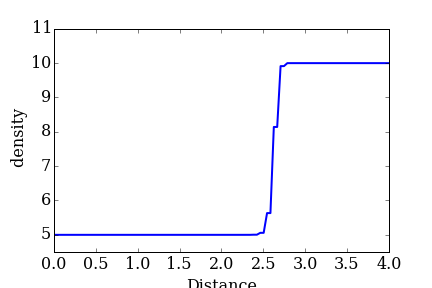
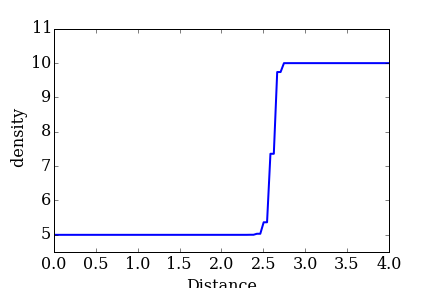
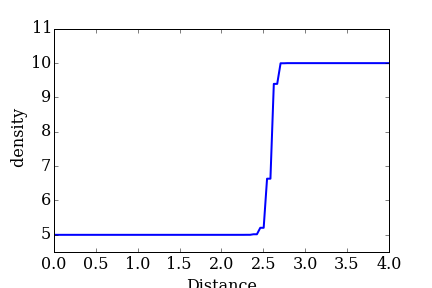
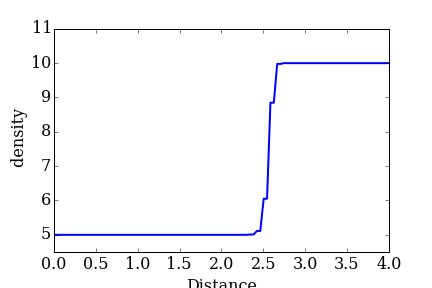
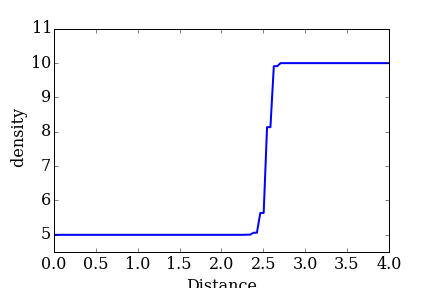
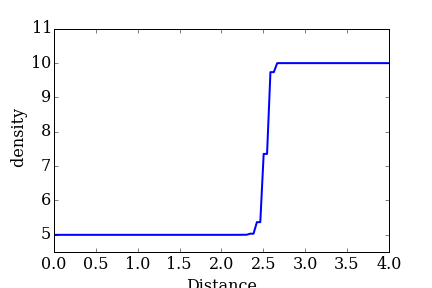
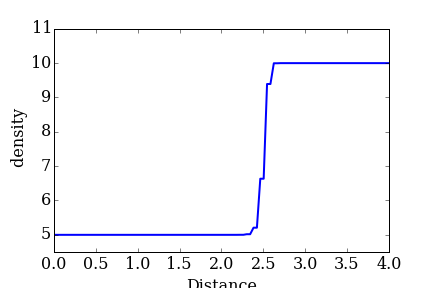
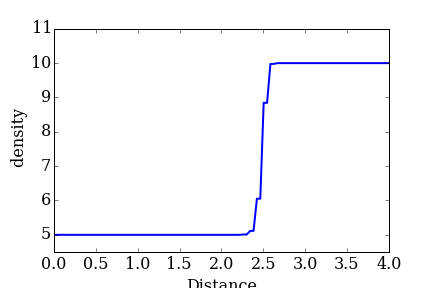
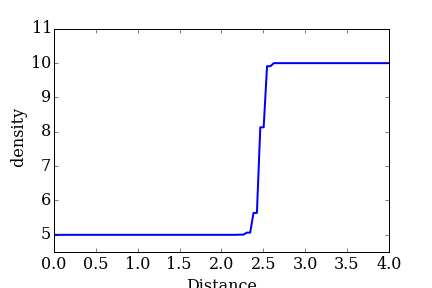
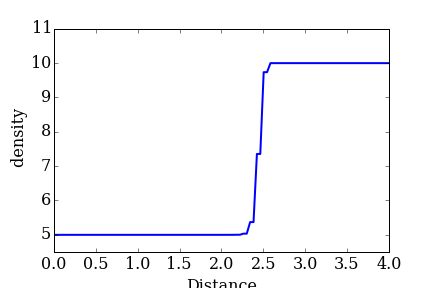
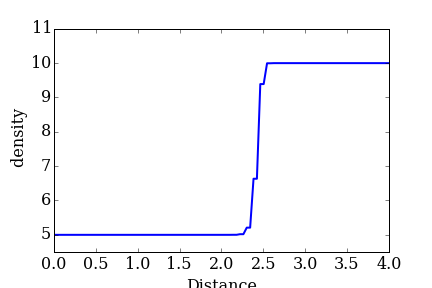
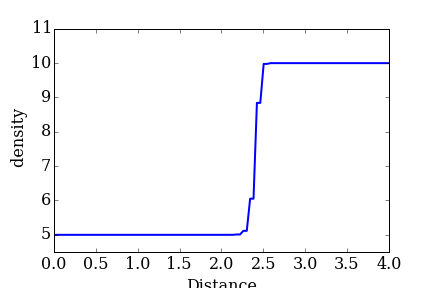
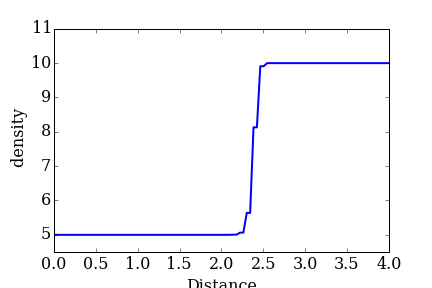

In [20]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=(' density'));
line, = ax.plot([],[], lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

Go back to Sod! Calculate the shock-tube problem using the MUSCL scheme and compare with your previous results. What do think?